# Detection - **Post-processing**

**Content**

- `clear_outside_frame_range` to remove the background off the track
- `remove_outliers`
- `interpolate_missing_coordinates` with `median_filter` and `Savitzky_Golay_filter`

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from sklearn.linear_model import RANSACRegressor, LinearRegression
from collections import deque

Auxiliary data and functions

In [234]:
def plot_coordinate(df):
    plt.figure(figsize=(3,6))
    plt.plot(df['x'], -df['y'], 'o-', label='Cleaned Trajectory', markersize=5)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Cleaned Ball Trajectory')
    plt.legend()
    plt.show()

In [235]:
def plot_coordinates(raw_df, cleaned_df):
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(6, 6))
    
    # Plot the original (raw) data on the left subplot
    axes[0].plot(raw_df['x'], -raw_df['y'], 'o-', label='Trajectory', markersize=5)
    axes[0].set_title('Previous Ball Trajectory')
    axes[0].set_xlabel('X Coordinate')
    axes[0].set_ylabel('Y Coordinate')
    axes[0].legend()
    
    # Plot the cleaned data on the right subplot
    axes[1].plot(cleaned_df['x'], -cleaned_df['y'], 'o-', label='Trajectory', markersize=5)
    axes[1].set_title('Processed Ball Trajectory')
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_ylabel('Y Coordinate')
    axes[1].legend()
    
    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()

In [236]:
def plot_comparison(df, df_cleaned):
    # Create a mask identifying outlier rows (i.e. those with NaN in x or y in the cleaned version)
    outlier_mask = df_cleaned[['x', 'y']].isna().any(axis=1)

    # Create a figure with two side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 6))
    
    # Plot 1: Original Data with Outliers Highlighted
    # Plot valid points from the original data (non-outliers)
    axes[0].plot(df.loc[~outlier_mask, 'x'], -df.loc[~outlier_mask, 'y'], 'o-', label='Valid Points', color='blue', markersize=5)
    # Overlay the outliers in red
    axes[0].plot(df.loc[outlier_mask, 'x'], -df.loc[outlier_mask, 'y'], 'o', label='Outliers', color='red', markersize=5)
    axes[0].set_xlabel('X Coordinate')
    axes[0].set_ylabel('Y Coordinate')
    axes[0].set_title('Original Points with Outliers Highlighted')
    axes[0].legend()
    
    # Plot 2: Cleaned Data
    # Plot only the non-NaN points from the cleaned DataFrame (which are the valid ones)
    valid_cleaned = df_cleaned.dropna(subset=['x', 'y'])
    axes[1].plot(valid_cleaned['x'], -valid_cleaned['y'], 'o-', label='Cleaned Trajectory', color='green', markersize=5)
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_ylabel('Y Coordinate')
    axes[1].set_title('Cleaned Points Only')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [237]:
def show_lines_on_frame(row, ax=None):
    bl = np.array([row['bottom_left_x'], row['bottom_left_y']])
    br = np.array([row['bottom_right_x'], row['bottom_right_y']])
    ul = np.array([row['up_left_x'], row['up_left_y']])
    ur = np.array([row['up_right_x'], row['up_right_y']])

    mid_bottom = (bl + br) / 2
    mid_upper = (ul + ur) / 2
    lifted_mid = mid_bottom + (mid_upper - mid_bottom) / 5

    # Direction vector along bottom line
    dir_vector = br - bl
    dir_vector = dir_vector / np.linalg.norm(dir_vector)

    # Create new lifted line endpoints
    p1 = lifted_mid - 200 * dir_vector
    p2 = lifted_mid + 200 * dir_vector

    # Create plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # Plot bottom line
    ax.plot([bl[0], br[0]], [bl[1], br[1]], 'b-', label='Bottom Line')

    # Plot up line
    ax.plot([ul[0], ur[0]], [ul[1], ur[1]], 'g-', label='Up Line')

    # Plot lifted (new) line
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r--', label='New (Lifted) Line')

    # Optionally plot ball position
    if not np.isnan(row['x']) and not np.isnan(row['y']):
        ax.plot(row['x'], row['y'], 'ro', label='Ball')

    #ax.set_aspect('equal')
    ax.invert_yaxis()  # Invert if image coordinate system
    ax.legend()
    ax.set_title(f"Lines on Frame {row['frame']}")
    plt.show()

Auxiliary function for the Radius

In [238]:
def plot_radius(df):
    plt.figure(figsize=(8,6))
    plt.plot(df['frame'], df['radius'], 'o-', label='Radius')
    plt.xlabel('Frame')
    plt.ylabel('Radius')
    plt.title('Radius over frames')
    plt.legend()
    plt.show()

In [239]:
def plot_fit(df, smoothed_df):
    plt.figure(figsize=(8,6))
    plt.plot(df['frame'], df['radius'], 'o-', label='Original Radius', alpha=0.5)
    plt.plot(smoothed_df['frame'], smoothed_df['radius'], '-', label='Exponential Fit', linewidth=2)
    plt.xlabel('frame')
    plt.ylabel('Radius')
    plt.title('Radius over frames')
    plt.legend()
    plt.show()

In [240]:
def plot_comparison_radius(df, df_cleaned):
    # Create a mask identifying outlier rows (i.e. those with NaN in the 'radius' column).
    outlier_mask = df_cleaned['radius'].isna()

    # Create a figure with two side-by-side subplots
    _, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Original Data with Outliers Highlighted
    # Plot valid points from the original data (non-outliers)
    axes[0].plot(df.loc[~outlier_mask, 'frame'], df.loc[~outlier_mask, 'radius'], 'o-', label='Valid Points', color='blue', markersize=5)
    # Overlay the outliers in red (removed the negative sign to keep the original values)
    axes[0].plot(df.loc[outlier_mask, 'frame'], df.loc[outlier_mask, 'radius'], 'o', label='Outliers', color='red', markersize=5)
    axes[0].set_xlabel('Frame')
    axes[0].set_ylabel('Radius')
    axes[0].set_title('Original Data with Outliers Highlighted')
    axes[0].legend()
    
    # Plot 2: Cleaned Data
    # Plot only the valid (non-NaN) points from the cleaned DataFrame
    valid_cleaned = df_cleaned.dropna(subset=['radius'])
    axes[1].plot(valid_cleaned['frame'], valid_cleaned['radius'], 'o-', label='Cleaned Data', color='green', markersize=5)
    axes[1].set_xlabel('Frame')
    axes[1].set_ylabel('Radius')
    axes[1].set_title('Cleaned Data (Outliers Removed)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

### Remove radius outliers

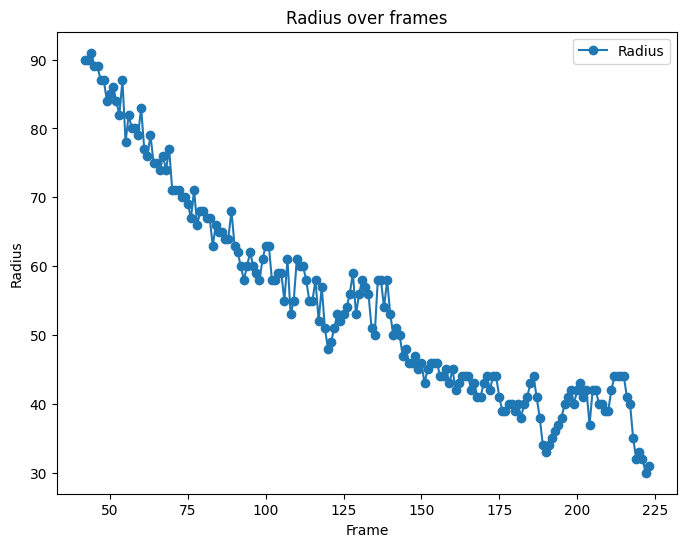

In [241]:
VIDEO_NUMBER = "2"
PROJECT_ROOT = Path().resolve().parent.parent
CSV_POSITIONS_FILE_PATH = str(PROJECT_ROOT / "notebook" / "ball_detection" / "intermediate_data" / f"Circle_positions_raw_{VIDEO_NUMBER}.csv")

df = pd.read_csv(CSV_POSITIONS_FILE_PATH)
plot_radius(df)

In [242]:
def decreasing_func(x, a, b, c):
    return a * np.exp(-b * x) + c  # Pure exponential decay function

In [243]:
def process_radius(df, median_window=25, quantile_baseline=0.05, ransac_threshold=0.5):
    # Ensure all frames are present
    all_frames = pd.DataFrame({'frame': np.arange(int(df['frame'].min()), int(df['frame'].max()) + 1)})
    df = pd.merge(all_frames, df, on='frame', how='left')

    # Smooth using rolling median
    df['median'] = df['radius'].rolling(window=median_window, center=True, min_periods=1).median()

    # Estimate baseline c using a low quantile
    c_est = df['radius'].quantile(quantile_baseline)

    # Prepare log-transformed target: log(radius - c)
    eps = 1e-6
    valid = df['radius'] > (c_est + eps)

    if valid.sum() < 10:
        raise ValueError("Too few valid points for robust fitting. Consider adjusting parameters.")

    x = df.loc[valid, 'frame'].values.reshape(-1, 1)
    y = np.log(df.loc[valid, 'radius'].values - c_est)

    # Robust regression in log-space
    ransac = RANSACRegressor(estimator=LinearRegression(), residual_threshold=ransac_threshold, max_trials=1000)
    ransac.fit(x, y)

    slope = -ransac.estimator_.coef_[0]
    intercept = ransac.estimator_.intercept_
    a_est = np.exp(intercept)

    # Predict over full frame range
    full_x = df['frame'].values
    fitted = decreasing_func(full_x, a_est, slope, c_est)
    df['radius'] = np.round(fitted).astype(int)

    return df

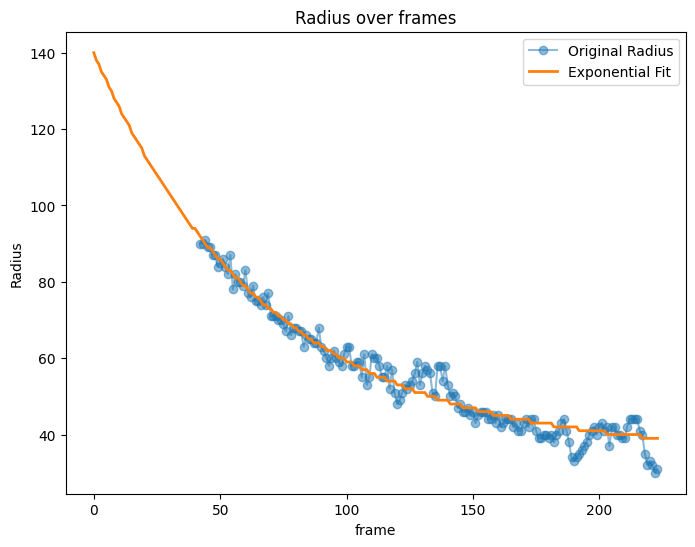

In [244]:
processed_df = process_radius(df, median_window=21, quantile_baseline=0.05, ransac_threshold=0.4)

plot_fit(df, processed_df)

In [245]:
def delete_outliers(df, processed_df):
    # Define the threshold for outliers (e.g., 25 units above or below the processed value)
    threshold = 10

    # Identify outliers by comparing raw radius to the processed (fitted) radius.
    outlier_mask = (df['radius'] > processed_df['radius'] + threshold) | (df['radius'] < processed_df['radius'] - threshold)

    # Create a copy so we do not modify the original DataFrame.
    cleaned_df = df.copy()

    # Instead of deleting rows, set the 'radius', 'x', and 'y' values to NaN for outlier rows.
    cleaned_df.loc[outlier_mask, ['radius', 'x', 'y']] = np.nan

    # Print the frame numbers of the outliers.
    outlier_frames = cleaned_df.loc[outlier_mask, 'frame'].tolist()
    print("Outlier frames:", outlier_frames)

    # Save the new DataFrame. (Assuming CSV_POSITIONS_FILE_PATH is defined globally.)
    #cleaned_df.to_csv(CSV_POSITIONS_FILE_PATH.replace("Circle_positions_raw", "Circle_positions_cleaned"), index=False)

    return cleaned_df

Outlier frames: []


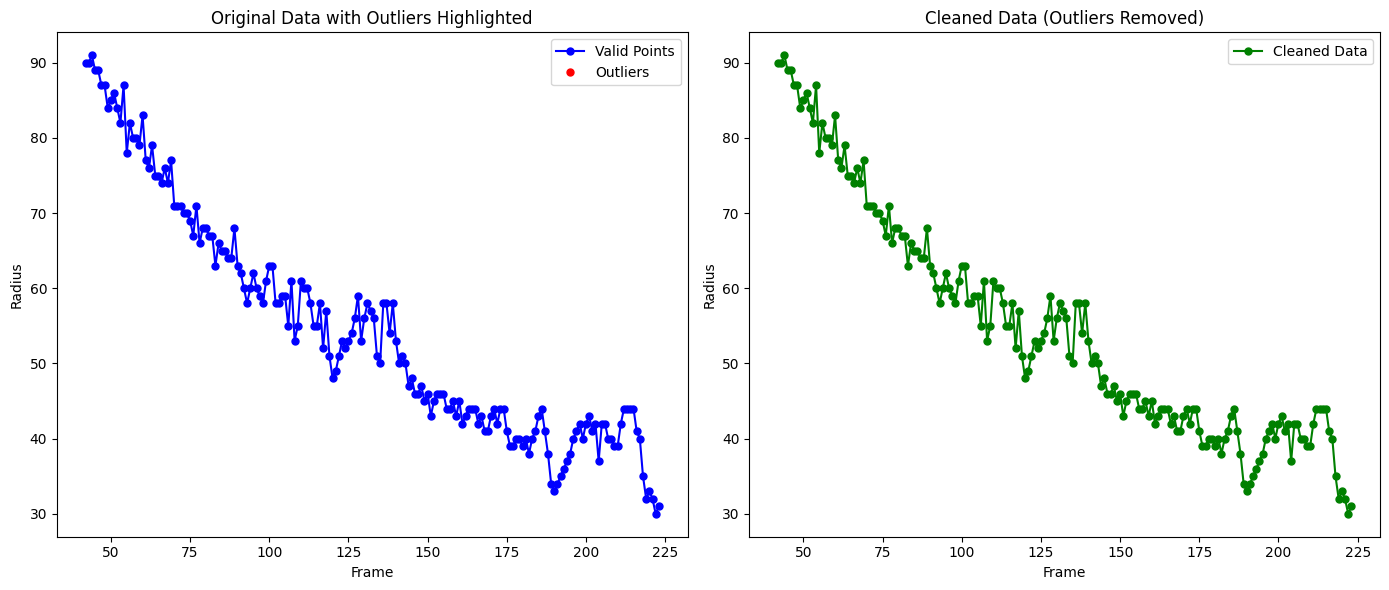

In [246]:
df_cleaned = delete_outliers(df, processed_df)

plot_comparison_radius(df, df_cleaned)

### Remove coordinates ouliers

Clean the points before a certain frame and after another one

I want to remove the points that cannot be the first ones. The first point must be upper a certain line and below another one, if the first are not in this range delete them.

In [247]:
# Example usage
VIDEO_NUMBER = "2"
PROJECT_ROOT = Path().resolve().parent.parent
CSV_POSITIONS_FILE_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "reconstructed_positions" / f"Transformed_positions_raw_{VIDEO_NUMBER}.csv")

df_coords = pd.read_csv(CSV_POSITIONS_FILE_PATH)

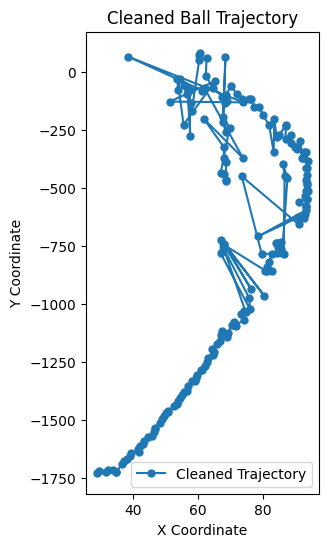

In [248]:
plot_coordinate(df_coords)

### Removing the coordinates that are out of the possible values

In [249]:
def remove_low_y_coordinates(df):
    # Copy to avoid modifying the original DataFrame
    df_cleaned = df.copy()

    # Convert 'y' to numeric in case it's not
    df_cleaned['y'] = pd.to_numeric(df_cleaned['y'], errors='coerce')

    # Mask condition: where y < -1750
    mask = (df_cleaned['y'] > 1750) | (df_cleaned['y'] < 30)

    # Set x and y to NaN where the mask is True
    df_cleaned.loc[mask, ['x', 'y']] = np.nan

    return df_cleaned

In [250]:
# Here when I encounter 5 y-coordinates that are less than 30, then, I will remove all the following coordinates
def remove_low_y_coordinates_v2(df):
    # Copy to avoid modifying the original DataFrame
    df_cleaned = df.copy()

    # Convert 'y' to numeric in case it's not
    df_cleaned['y'] = pd.to_numeric(df_cleaned['y'], errors='coerce')

    # Initialize a counter for low y-coordinates
    low_y_count = 0

    # Create a deque to keep track of the last 5 y-coordinates
    last_five_y = deque(maxlen=4)

    for index, row in df.iterrows():
        last_five_y.append(row['y'])

        # Check if there are 5 y-coordinates less than 30
        if len(last_five_y) == 4 and all(y < 110 for y in last_five_y):
            low_y_count += 1

        # If we have encountered 5 low y-coordinates, set x and y to NaN
        if low_y_count >= 4:
            df_cleaned.loc[index, ['x', 'y']] = np.nan

    return df_cleaned

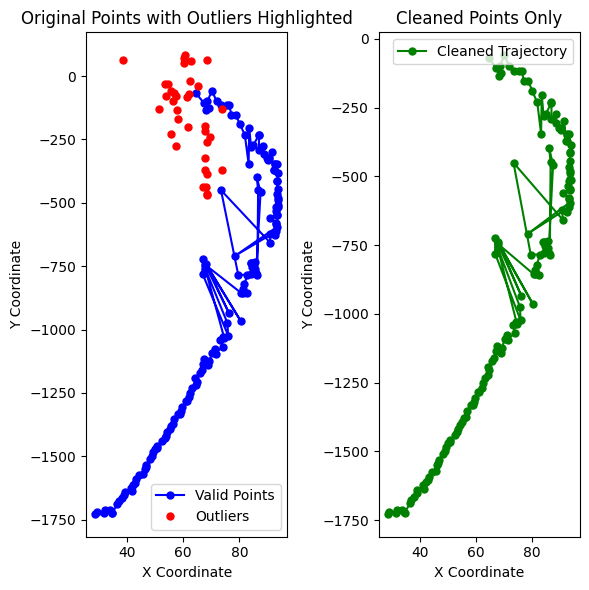

In [251]:
df_final = remove_low_y_coordinates_v2(df_coords)
df_final = remove_low_y_coordinates(df_final)
plot_comparison(df_coords, df_final)

### Removing the outliers

In [252]:
def rolling_median_mad(values, window_size):
    median_values = []
    mad_values = []

    window = deque(maxlen=window_size)

    for value in values:
        window.append(value)
        if len(window) == window_size:
            median = np.median(window)
            mad = np.median(np.abs(np.array(window) - median))
            median_values.append(median)
            mad_values.append(mad)
        else:
            median_values.append(np.nan)
            mad_values.append(np.nan)

    return np.array(median_values), np.array(mad_values)

In [253]:
def remove_outliers_with_rolling(df: pd.DataFrame, threshold: float = 2.5, window_size: int = 2) -> pd.DataFrame:
    
    # Copy the original DataFrame
    df_clean = df.copy()

    # Store initial NaN positions
    initial_nan_mask = df_clean[['x', 'y']].isna().any(axis=1)

    # Rolling median and MAD for x and y coordinates
    x_median, x_mad = rolling_median_mad(df_clean['x'].values, window_size)
    y_median, y_mad = rolling_median_mad(df_clean['y'].values, window_size)
    
    # Compute Euclidean distance from rolling median
    distances = np.sqrt((df_clean['x'].values - x_median) ** 2 + (df_clean['y'].values - y_median) ** 2)

    # Avoid division by zero
    if np.nanmedian(np.abs(distances - np.nanmedian(distances))) == 0:
        return df_clean

    # Modified z-scores
    modified_z = 0.6745 * (distances - np.nanmedian(distances)) / np.nanmedian(np.abs(distances - np.nanmedian(distances)))

    # Identify outliers
    mask_outliers = np.abs(modified_z) < threshold

    # Set x and y to NaN for new outliers only
    new_outlier_mask = ~mask_outliers & ~initial_nan_mask
    df_clean.loc[new_outlier_mask, ['x', 'y']] = np.nan

    # Print only newly detected outlier frames
    outlier_frames = df.loc[new_outlier_mask, 'frame'].tolist()
    print("Outlier frames:", outlier_frames)

    return df_clean

Outlier frames: [42, 105, 106, 108, 109, 110, 111, 112, 113, 114, 119, 128, 129, 130, 131, 133, 134, 138, 139, 161, 168, 172, 173, 174]


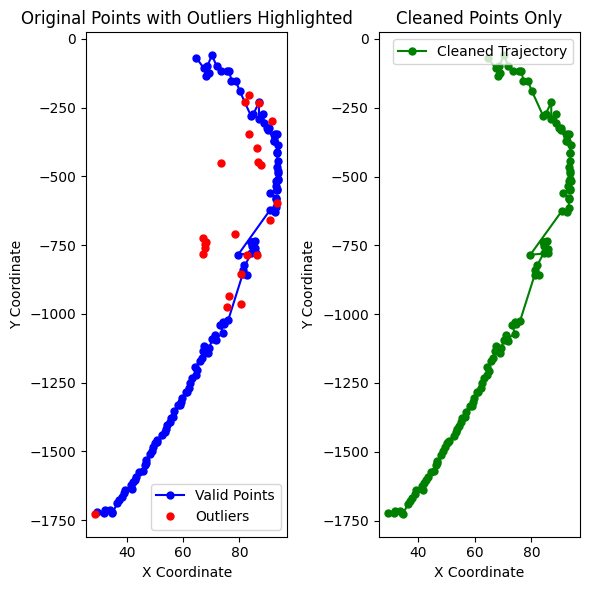

In [254]:
df_filtered = remove_outliers_with_rolling(df_final)

#plot_coordinate(df_filtered)
plot_comparison(df_final, df_filtered)

### Post-processing interpolation

In [255]:
def median_filter(df, kernel_size=3):
    df = df.copy()
    # Apply a median filter to smooth the coordinates (kernel size 5 by default)
    df['x'] = medfilt(df['x'], kernel_size=kernel_size)
    df['y'] = medfilt(df['y'], kernel_size=kernel_size)

    df = df[df['x'] > 0] # Because I had the problem witht he point 0,0 (I don't know why)
    df = df[df['y'] > 0] 
    return df

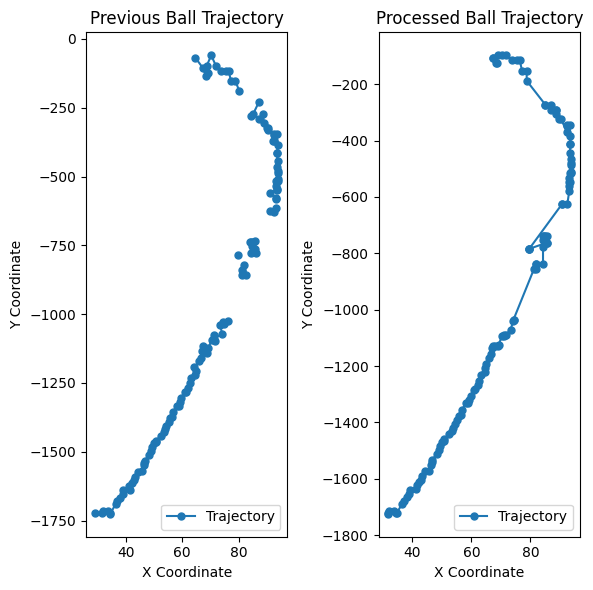

In [256]:
# Smooth the trajectory to reduce noise
df_smoothed = median_filter(df_filtered)

plot_coordinates(df_filtered, df_smoothed)

In [257]:
# Save cleaned data
#OUTPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "ball_detection" / "intermediate_data" / f"Trasformed_positions_cleaned_{VIDEO_NUMBER}.csv")
#df_cleaned.to_csv(OUTPUT_CSV_PATH, index=False)

TODO: start and finish detection when the ball enters and exits the track (required track detection). How to know when the ball is arrived at the end?

Do not do the interpolation with this data but with the data reconstructed on the lane reconstruction!!!

In [258]:
def Savitzky_Golay_filter(df, window_length=45, polyorder=3):
    df = df.copy()
    df['x'] = savgol_filter(df['x'], window_length=window_length, polyorder=polyorder)
    df['y'] = savgol_filter(df['y'], window_length=window_length, polyorder=polyorder)
    # Round the smoothed coordinates to integers
    df['x'] = df['x'].round().astype(int)
    df['y'] = df['y'].round().astype(int)

    return df

In [259]:
def interpolate_missing_coordinates(df):
    # Copy and set "frame" as the index
    df = df.copy().set_index('frame')
    
    # Create a new index that includes all frames from first to last
    full_index = range(df.index.min(), df.index.max() + 1)
    df_full = df.reindex(full_index)
    
    # Interpolate missing 'x' and 'y' coordinates (linear interpolation)
    df_full['x'] = df_full['x'].interpolate(method='linear')
    df_full['y'] = df_full['y'].interpolate(method='linear')
    
    # Fill any remaining NaN values using forward and backward filling
    df_full['x'] = df_full['x'].bfill().ffill()
    df_full['y'] = df_full['y'].bfill().ffill()
    
    # Reset index to bring the "frame" column back
    df_full = df_full.reset_index().rename(columns={'index': 'frame'})
    
    # Apply smoothing to ensure a smooth trajectory
    df_full = Savitzky_Golay_filter(df_full)
    
    return df_full

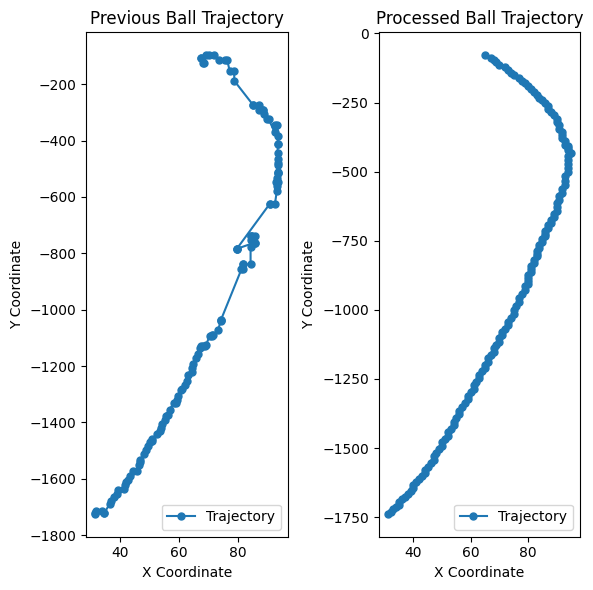

In [260]:
df_interpolated = interpolate_missing_coordinates(df_smoothed)
plot_coordinates(df_smoothed, df_interpolated)

In [261]:
# Save the smoothed and interpolated data
#OUTPUT_CSV_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "reconstructed_positions" / f"Transformed_positions_processed_{VIDEO_NUMBER}.csv")
#df_interpolated.to_csv(OUTPUT_CSV_PATH, index=False)